In [1]:
import dill
import matplotlib.pyplot as plt
# Compute number of all child nodes for each node and categorize by level

def count_all_children(node):
    """Recursively count all descendant nodes (children, grandchildren, etc.) for a given node."""
    if node.left is None and node.right is None:
        return 0
    count = 0
    if node.left is not None:
        count += 1 + count_all_children(node.left)
    if node.right is not None:
        count += 1 + count_all_children(node.right)
    return count

def get_node_level(node, current_level=0, level_dict=None):
    """Recursively assign nodes to their level in the tree."""
    if level_dict is None:
        level_dict = {}
    if current_level not in level_dict:
        level_dict[current_level] = []
    level_dict[current_level].append(node)
    if node.left is not None:
        get_node_level(node.left, current_level + 1, level_dict)
    if node.right is not None:
        get_node_level(node.right, current_level + 1, level_dict)
    return level_dict


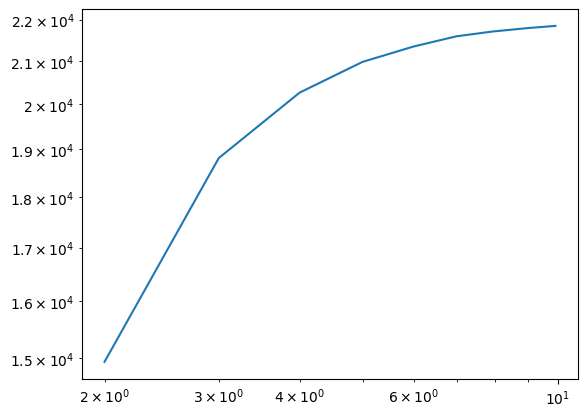

In [45]:
ratio=np.linspace(1,10,10)
eps=8.6*ratio
y=[]
nodes=[]
for j in eps:
    for i in data.res.abs_gaps:
        if i<j:
            y.append(i)
            nodes.append(data.res.bb_n[data.res.abs_gaps.index(i)])
            break
diff_y=[]
diff_nodes=[]
for idx,i in enumerate(y):
    if idx<len(y)-1:
        diff_nodes.append(abs(nodes[idx+1]-nodes[0]))
        diff_y.append(y[idx+1]/y[0])
plt.loglog(diff_y,diff_nodes)

In [48]:
diff_y,diff_nodes

([1.9986658242954132,
  2.999086495039838,
  3.9972377469737714,
  4.9969413117266654,
  5.991361922651207,
  6.975572331889363,
  7.959357478688708,
  8.996651992979062,
  9.915734734061996],
 [14942, 18814, 20260, 20976, 21344, 21592, 21712, 21794, 21848])

In [46]:
from scipy.stats import linregress

# Fit a linear line to nodes (x) and y (y)
slope, intercept, r_value, p_value, std_err = linregress(np.log(diff_y), np.log(diff_nodes))
print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")

Slope: 0.20781144633783172, Intercept: 9.566980890304398, R^2: 0.8094265433982318


## L-test

In [1]:
from pyomo.environ import *
from pyomo.core.expr.calculus.derivatives import differentiate
from src.models.cz_model import CaoZavalaModel, CaoZavalaAlgo
from src.analyses.convergence_analysis import HausdorffAnalyzer
import dill

# from NSPLIB.src.instances.process.process_SP import const_model  #infeasible direction d lemma 5 failed
# sto_m = const_model()
# m = CaoZavalaModel.from_sto_m(sto_m)
# m.build()

# from NSPLIB.src.instances.ex8_4_4.ex8_4_4_SP import const_model   #0 purely equality constraints Proporisiton 2 in Kannan paper failed
# sto_m = const_model()
# m = CaoZavalaModel.from_sto_m(sto_m)
# m.build()

from NSPLIB.src.instances.pooling_contract_selection.pooling import const_model #0.7 satisfies the conditions of Proposition 2 in Kannan paper
sto_m = const_model()
m = CaoZavalaModel.from_sto_m(sto_m)
m.build()
binary_ys = ['lambd[1]', 'lambd[2]', 'lambd[3]', 'lambd[4]', 'lambd[5]', 'theta[1]', 'theta[2]', 'theta[3]', 'theta[4]']

binary_y_val = {y: 0 for y in binary_ys}
binary_y_val['lambd[1]'] = 1
binary_y_val['lambd[2]'] = 1
binary_y_val['lambd[5]'] = 1
binary_y_val['theta[1]'] = 1
binary_y_val['theta[4]'] = 1
m.fix_binary_y(binary_y_val)


# from NSPLIB.src.instances.crude_selection.crude_selection import const_model #infeasible direction d lemma 5 failed
# sto_m = const_model()
# m = CaoZavalaModel.from_sto_m(sto_m)
# m.build()
# binary_ys = [f'pickCrude[{i}]' for i in range(1, 10 + 1)]
# binary_y_val = {y: 0 for y in binary_ys}
# binary_y_val['pickCrude[2]'] = 1
# binary_y_val['pickCrude[3]'] = 1
# binary_y_val['pickCrude[4]'] = 1
# binary_y_val['pickCrude[8]'] = 1
# binary_y_val['pickCrude[10]'] = 1
# m.fix_binary_y(binary_y_val)
# updated_y_bound=m.y_bound
# updated_y_bound['crudeQuantity[1]']=(0,0)
# updated_y_bound['crudeQuantity[5]']=(0,0)
# updated_y_bound['crudeQuantity[6]']=(0,0)
# updated_y_bound['crudeQuantity[7]']=(0,0)
# updated_y_bound['crudeQuantity[9]']=(0,0)
# m.update_y_bound(updated_y_bound)

from pyomo.opt import SolverFactory
solver = SolverFactory('baron')
#solver.options['AbsConFeasTol'] = 1e-12
solver.solve(m.origin_model,tee=True)


 BARON version 25.3.19. Built: OSX-64 2025-03-19 22:00:43         
 Running on machine Jingzhis-MacBook-Air.local

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Jingzhi Yang at Georgia Institute of Technology, jyang872@gatech.edu.

 If you publish work using this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Zhang, Y. and N. V. Sahinidis, Solving continuous and discrete
 nonlinear programs with BARON, Comput Optim Appl (2024). 
 https://doi.org/10.1007/s10589-024-00633-0
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: FILTERSQP
 Doing local search
 Preprocessing found feasible solution with value 1260.00
 Solving bounding LP
 Starting multi-start local search
 Preprocessing found feasible solution with value -1206.14
 Done with local search
  Iteration       Time (s)     Mem   Lower bound  

{'Problem': [{'Name': 'problem', 'Lower bound': -1338.2471283376399, 'Upper bound': -1338.2471283376399, 'Number of objectives': 1, 'Number of constraints': 433, 'Number of variables': 394, 'Sense': 'unknown', 'Missing bounds': '0', 'Iterations': '13', 'Node opt': '13', 'Node memmax': '7', 'Cpu time': 3.62, 'Wall time': 3.66}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Root node time': 0.23, 'Error rc': 0, 'Time': 3.9114370346069336}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In [2]:
from pyomo.core.expr.relational_expr import EqualityExpression, InequalityExpression
constraints = [c for c in m.origin_model.component_objects(Constraint, active=True)]
first_names=list(m.origin_model.y.keys())
equality_constraints = []
active_inequality_constraints = []
# if variable value is none set it to 0 to compute the Jacobian correctly
for v in m.origin_model.component_data_objects(Var, descend_into=True, active=True):
    if v.value is None:
        v.set_value(0)
# Collect equality and active inequality constraints into two dictionaries
for c in constraints:
    expr = c.expr
    if isinstance(expr, EqualityExpression):
        equality_constraints.append(c.name)
    elif isinstance(expr, InequalityExpression):
        if c.lower is None and abs(value(c)-value(c.upper))<1e-8:
            active_inequality_constraints.append(c.name)
        elif c.upper is None and abs(value(c)-value(c.lower))<1e-8:
            active_inequality_constraints.append(c.name)
        elif c.lower is not None and c.upper is not None:
            if abs(value(c)-value(c.lower))<1e-8 or abs(value(c)-value(c.upper))<1e-8:
                active_inequality_constraints.append(c.name)

jacobian_equality = {}
jacobian_inequality = {}
# Compute the Jacobian of equality constraints with respect to m.origin_model.y
for cname in equality_constraints:
    c_obj = m.origin_model.find_component(cname)
    jacobian_equality[cname] = []
    for vname in first_names:
        var = m.origin_model.y[vname]
        # For indexed constraints, differentiate each index
        expr = c_obj.expr.args[0]
        deriv = differentiate(expr, wrt=var)
        expr = c_obj.expr.args[1]
        deriv -= differentiate(expr, wrt=var)
        jacobian_equality[cname].append((vname, deriv))

# Compute the Jacobian of active inequality constraints with respect to m.origin_model.y
for cname in active_inequality_constraints:
    c_obj = m.origin_model.find_component(cname)
    jacobian_inequality[cname] = []
    for vname in first_names:
        var = m.origin_model.y[vname]
        # For indexed constraints, differentiate each index
        expr = c_obj.expr.args[0]
        deriv = differentiate(expr, wrt=var)
        expr = c_obj.expr.args[1]
        deriv -= differentiate(expr, wrt=var)
        jacobian_inequality[cname].append((vname, deriv))
        
# Compute the Jacobian of the objective function with respect to m.origin_model.y
objective_expr = m.origin_model.obj.expr
jacobian_obj = []
for vname in first_names:
    var = m.origin_model.y[vname]
    deriv = differentiate(objective_expr, wrt=var)
    jacobian_obj.append((vname, deriv))


In [3]:
from pyomo.environ import ConcreteModel, Var

# Create a new Pyomo model
model = ConcreteModel()

# Use the same index and dimension as m.origin_model.y
model.d = Var(m.origin_model.y.index_set())
model.sum_abs_constraint = Constraint(expr=sum(abs(model.d[i]) for i in model.d.index_set()) == 1)

#  check if global solution lies on variable bound
for key in m.origin_model.y:
    var = m.origin_model.y[key]
    lb = var.lb
    ub = var.ub
    val = var.value
    # Check if variable is binary
    if var.is_binary():
        model.add_component(key, Constraint(expr=model.d[key] == 0))
        continue
    if lb is not None and abs(val - lb) < 1e-8:
        model.add_component(f"Lower_Bound_{key}", Constraint(expr=model.d[key] >= 0))
    if ub is not None and abs(val - ub) < 1e-8:
        model.add_component(f"Upper_Bound_{key}", Constraint(expr=model.d[key] <= 0))

# create constraint for each jacobian_equality
for cname, jacobian in jacobian_equality.items():
    
    model.add_component(cname, Constraint(expr=sum(jacobian[i][1] * model.d[jacobian[i][0]] for i in range(len(jacobian))) == 0))
for cname, jacobian in jacobian_inequality.items():
    model.add_component(cname, Constraint(expr=sum(jacobian[i][1] * model.d[jacobian[i][0]] for i in range(len(jacobian))) <= 0))
# Add objective function using jacobian_obj
model.obj = Objective(expr=sum(jacobian_obj[i][1] * model.d[jacobian_obj[i][0]] for i in range(len(jacobian_obj))), sense=minimize)

from pyomo.opt import SolverFactory
solver = SolverFactory('baron')
solver.solve(model, tee=True)

 BARON version 25.3.19. Built: OSX-64 2025-03-19 22:00:43         
 Running on machine Jingzhis-MacBook-Air.local

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Jingzhi Yang at Georgia Institute of Technology, jyang872@gatech.edu.

 If you publish work using this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Zhang, Y. and N. V. Sahinidis, Solving continuous and discrete
 nonlinear programs with BARON, Comput Optim Appl (2024). 
 https://doi.org/10.1007/s10589-024-00633-0
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: FILTERSQP
 Preprocessing found feasible solution with value 0.700000
 Problem solved during preprocessing
 Lower bound is   0.700000

                         *** Normal completion ***            

 Wall clock time:                     0.01
 Total CPU time used:               

{'Problem': [{'Name': 'problem', 'Lower bound': 0.7, 'Upper bound': 0.7, 'Number of objectives': 1, 'Number of constraints': 395, 'Number of variables': 19, 'Sense': 'unknown', 'Missing bounds': '0', 'Iterations': '-1', 'Node opt': '-1', 'Node memmax': '0', 'Cpu time': 0.0, 'Wall time': 0.0}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Root node time': -100, 'Error rc': 0, 'Time': 0.053809165954589844}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In [4]:
model.d.display()

d : Size=18, Index={S[1], S[2], S[3], S[4], A[1], A[2], A[3], A[4], A[5], lambd[1], lambd[2], lambd[3], lambd[4], lambd[5], theta[1], theta[2], theta[3], theta[4]}
    Key      : Lower : Value : Upper : Fixed : Stale : Domain
        A[1] :  None :  -0.0 :  None : False : False :  Reals
        A[2] :  None :  -0.0 :  None : False : False :  Reals
        A[3] :  None :   0.0 :  None : False : False :  Reals
        A[4] :  None :   0.0 :  None : False : False :  Reals
        A[5] :  None :   1.0 :  None : False : False :  Reals
        S[1] :  None :  -0.0 :  None : False : False :  Reals
        S[2] :  None :   0.0 :  None : False : False :  Reals
        S[3] :  None :   0.0 :  None : False : False :  Reals
        S[4] :  None :  -0.0 :  None : False : False :  Reals
    lambd[1] :  None :   0.0 :  None : False : False :  Reals
    lambd[2] :  None :   0.0 :  None : False : False :  Reals
    lambd[3] :  None :   0.0 :  None : False : False :  Reals
    lambd[4] :  None :   0.0 :

In [5]:
import numpy as np

# Combine all constraint names and their Jacobians
all_jacobians = []
all_constraint_names = []

for cname, jac in jacobian_equality.items():
    all_jacobians.append([coef for _, coef in jac])
    all_constraint_names.append(cname)
# for cname, jac in jacobian_inequality.items():
#     all_jacobians.append([coef for _, coef in jac])
#     all_constraint_names.append(cname)

# Stack into a matrix (rows: constraints, columns: variables in first_names)
A = np.array(all_jacobians)
print("Constraint coefficient matrix shape:", A.shape)

Constraint coefficient matrix shape: (162, 18)


In [6]:
from numpy.linalg import matrix_rank

# Find linearly independent rows of A
def get_independent_rows(A):
    independent_rows = []
    current_rows = []
    for i in range(A.shape[0]):
        test_rows = current_rows + [A[i]]
        if matrix_rank(np.vstack(test_rows)) > len(current_rows):
            independent_rows.append(i)
            current_rows.append(A[i])
    return np.array(independent_rows)

independent_row_indices = get_independent_rows(A)
A_independent = A[independent_row_indices]
print("Shape of A with only independent rows:", A_independent.shape)

Shape of A with only independent rows: (4, 18)


In [7]:
A_independent

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
         0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        -1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, -1]])